<a href="https://colab.research.google.com/github/Ofir-Manor/Long3/blob/main/316084623-311288203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> HW3 Major</h1>
<h1 align="center"> Regression</h1>

# Setting the Environment

In [1]:
#@title Setting the Environment:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from typing import Union
params = {
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.titlesize' : 22,
    'axes.labelsize' : 20,
    'legend.fontsize': 18,
    'legend.title_fontsize': 22,
    'figure.titlesize': 24
 }
pylab.rcParams.update(params)

## Preliminary: Updated Data Loading

In [2]:
'''
#@title Loading the dataset and the code files:
# load the csv file:
!rm *.csv
from google.colab import files
print("Please load the raw csv data: HW3_data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
'''

'\n#@title Loading the dataset and the code files:\n# load the csv file:\n!rm *.csv\nfrom google.colab import files\nprint("Please load the raw csv data: HW3_data")\nuploadedData = files.upload()\nfilename = list(uploadedData)[0]\n'

In [3]:
# Jupyter Lab
filename = "HW3_data.csv"

In [4]:
#@title Create DF and split it:

dataset = pd.DataFrame(pd.read_csv(filename))
from sklearn.model_selection import train_test_split
random_state = 3 + 23
train_raw, test_raw = train_test_split(dataset, test_size=0.2, random_state=random_state)

#@title Use `prepare` function:

In [5]:
from prepare_hw3 import prepare_data
# Prepare training set according to itself
train = prepare_data(train_raw, train_raw)
# Prepare test set according to the raw training data
test = prepare_data(train_raw, test_raw)

# Question 2

In [6]:
# Prep Linear Regressor training and validation set
from LinearRegressor import LinearRegressor
lin_reg_train, lin_reg_val = train_test_split(train, test_size=0.2, random_state=random_state)
lin_reg_train_x = lin_reg_train[lin_reg_train.columns.difference(["contamination_level"])]
lin_reg_train_y = lin_reg_train["contamination_level"]
lin_reg_val_x = lin_reg_val[lin_reg_val.columns.difference(["contamination_level"])]
lin_reg_val_y = lin_reg_val["contamination_level"]

In [7]:
# Copy of verify_gradients.py
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

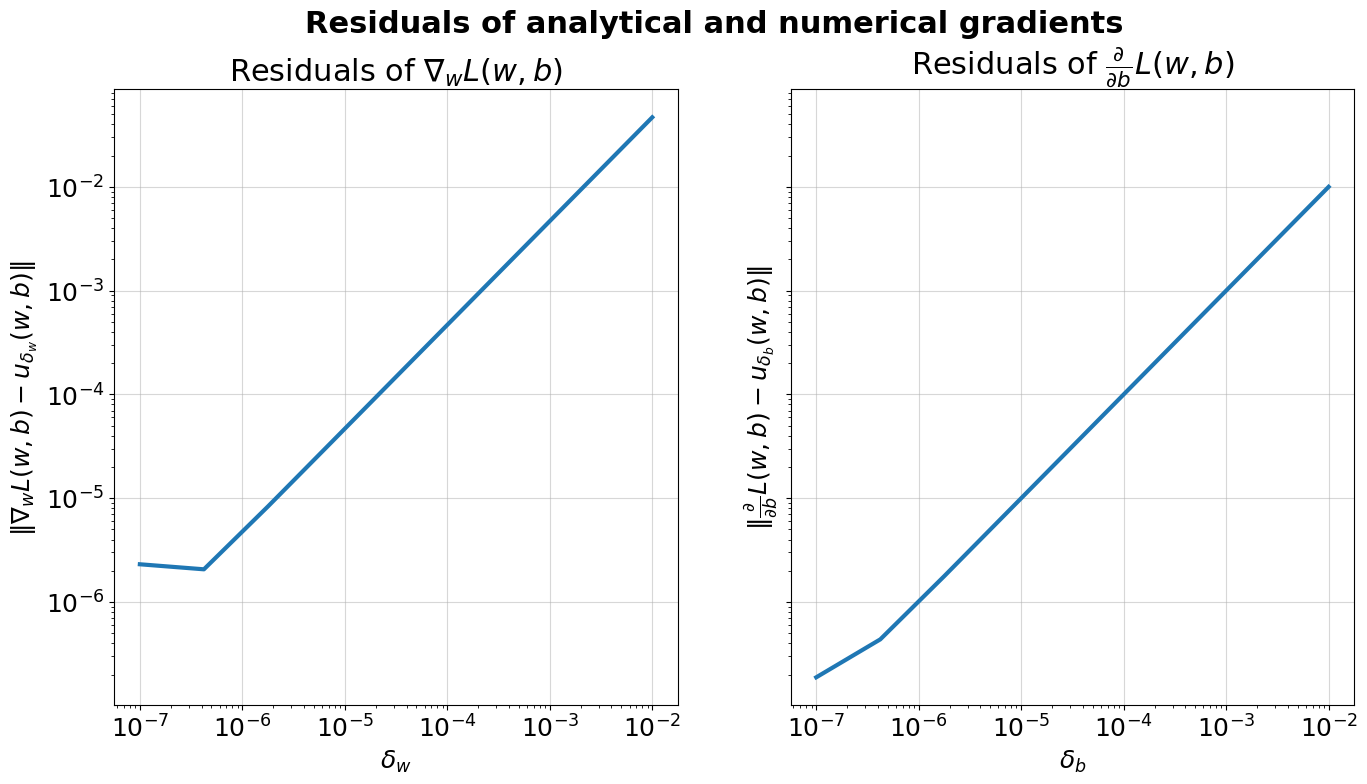

In [8]:
compare_gradients(lin_reg_train_x, lin_reg_train_y, deltas=np.logspace(-7, -2, 9))

# Question 3

In [9]:
# Copy of test_lr.py
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 387.4981802595634, Best validation loss = 421.5168420204055
lr size = 1e-08, Best train loss = 387.4487131166349, Best validation loss = 421.4671246584343
lr size = 1e-07, Best train loss = 386.9545740122952, Best validation loss = 420.9704813270224
lr size = 1e-06, Best train loss = 382.0660211082413, Best validation loss = 416.0566864215049
lr size = 1e-05, Best train loss = 338.09119751217077, Best validation loss = 371.81312331068693
lr size = 0.0001, Best train loss = 159.55779983992582, Best validation loss = 190.81767142386246
lr size = 0.001, Best train loss = 97.34239765483836, Best validation loss = 128.17551760233803
lr size = 0.01, Best train loss = 90.77378254595253, Best validation loss = 117.01114805168658
lr size = 0.1, Best train loss = 93.25528699440298, Best validation loss = 117.4817515745496


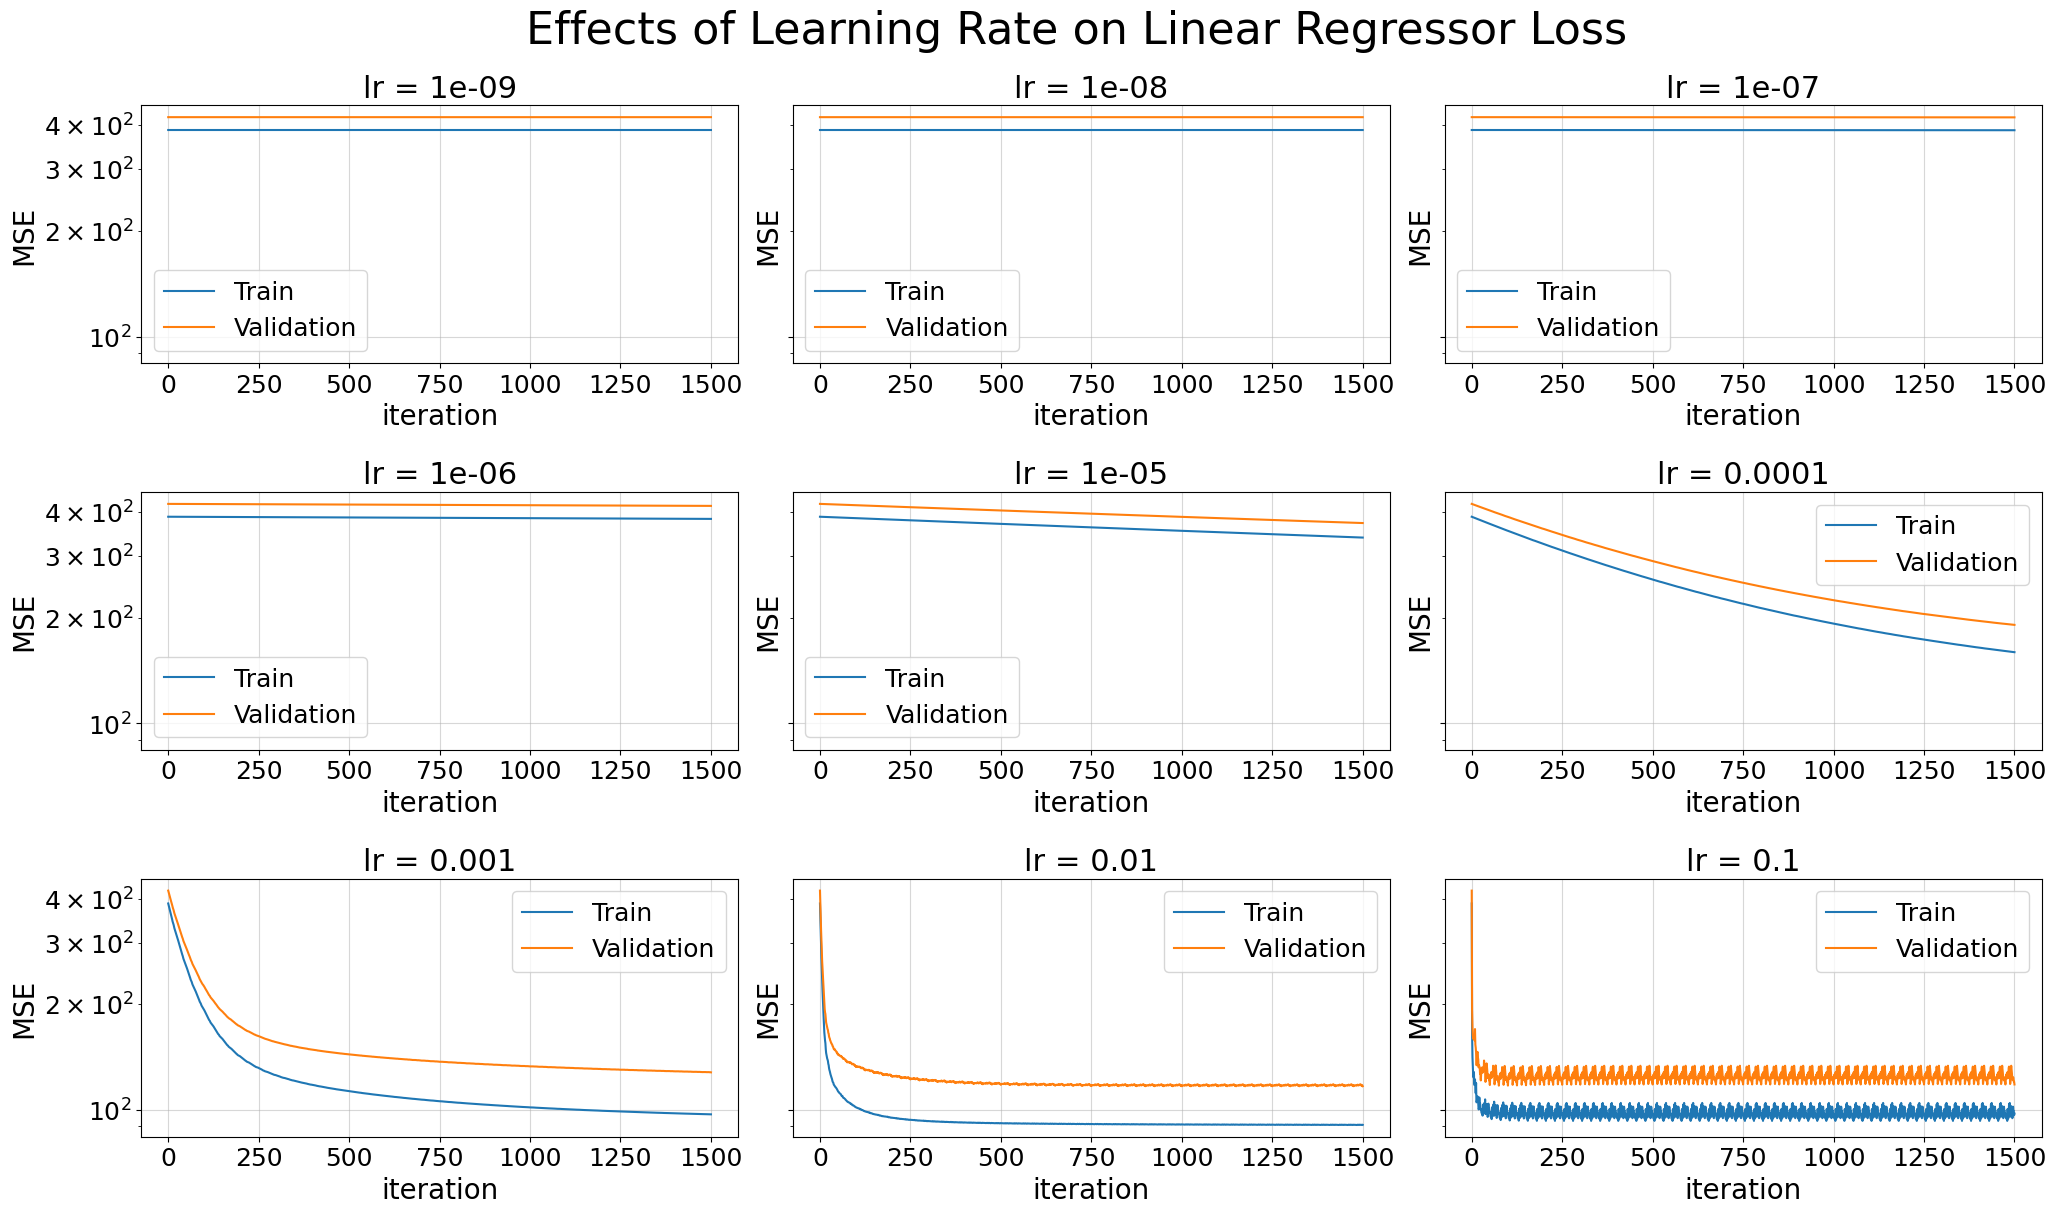

In [10]:
test_lr(lin_reg_train_x, lin_reg_train_y, lin_reg_val_x, lin_reg_val_y, title="Effects of Learning Rate on Linear Regressor Loss")

# Section 2: Evaluation and Baseline

# Question 4

In [11]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

train_X = train[train.columns.difference(["contamination_level"])]
train_y = train["contamination_level"]

dummy_regr = DummyRegressor(strategy="mean")

cv_dummy_regr_scores = cross_validate(dummy_regr, train_X, train_y, scoring="neg_mean_squared_error", cv=5, return_train_score=True)
print(f"The training MSE Scores are {cv_dummy_regr_scores['train_score']} and their average is {np.mean(cv_dummy_regr_scores['train_score'])}")
print(f"The validation MSE Scores are {cv_dummy_regr_scores['test_score']} and their average is {np.mean(cv_dummy_regr_scores['test_score'])}")

dummy_redr_train_loss = np.mean(cv_dummy_regr_scores['test_score'])
dummy_redr_val_loss = np.mean(cv_dummy_regr_scores['test_score'])

The training MSE Scores are [-105.14856234 -105.33416548 -105.85261118 -102.05445569 -110.72023985] and their average is -105.82200690688448
The validation MSE Scores are [-108.82678915 -107.96370075 -105.94952923 -121.1517169   -87.07070676] and their average is -106.19248855899191


In [12]:
dummy_regr.fit(train_X, train_y)

DummyRegressor()

# Question 5

In [13]:
def semilogx_plot(hp_list, cv_train_score, cv_val_score, dummy_train_score, dummy_val_score, hp_title, model_title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 12))
    plt.suptitle(f"Cross Vlaidation of {model_title} by {hp_title}", fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, top=0.9)
    axs = np.ravel(axs)
    
    axs[0].semilogx(hp_list, cv_train_score, label=model_title)
    axs[0].semilogx(hp_list, dummy_train_score, label="Dummy Regressor")
    axs[0].grid(alpha = 0.5)
    axs[0].legend()
    axs[0].set_title("Training")
    axs[0].set_xlabel(hp_title)
    axs[0].set_ylabel('MSE')
    
    axs[1].semilogx(hp_list, cv_val_score, label=model_title)
    axs[1].semilogx(hp_list, dummy_val_score, label="Dummy Regressor")
    axs[1].grid(alpha = 0.5)
    axs[1].legend()
    axs[1].set_title("Validation")
    axs[1].set_xlabel(hp_title)
    axs[1].set_ylabel('MSE')

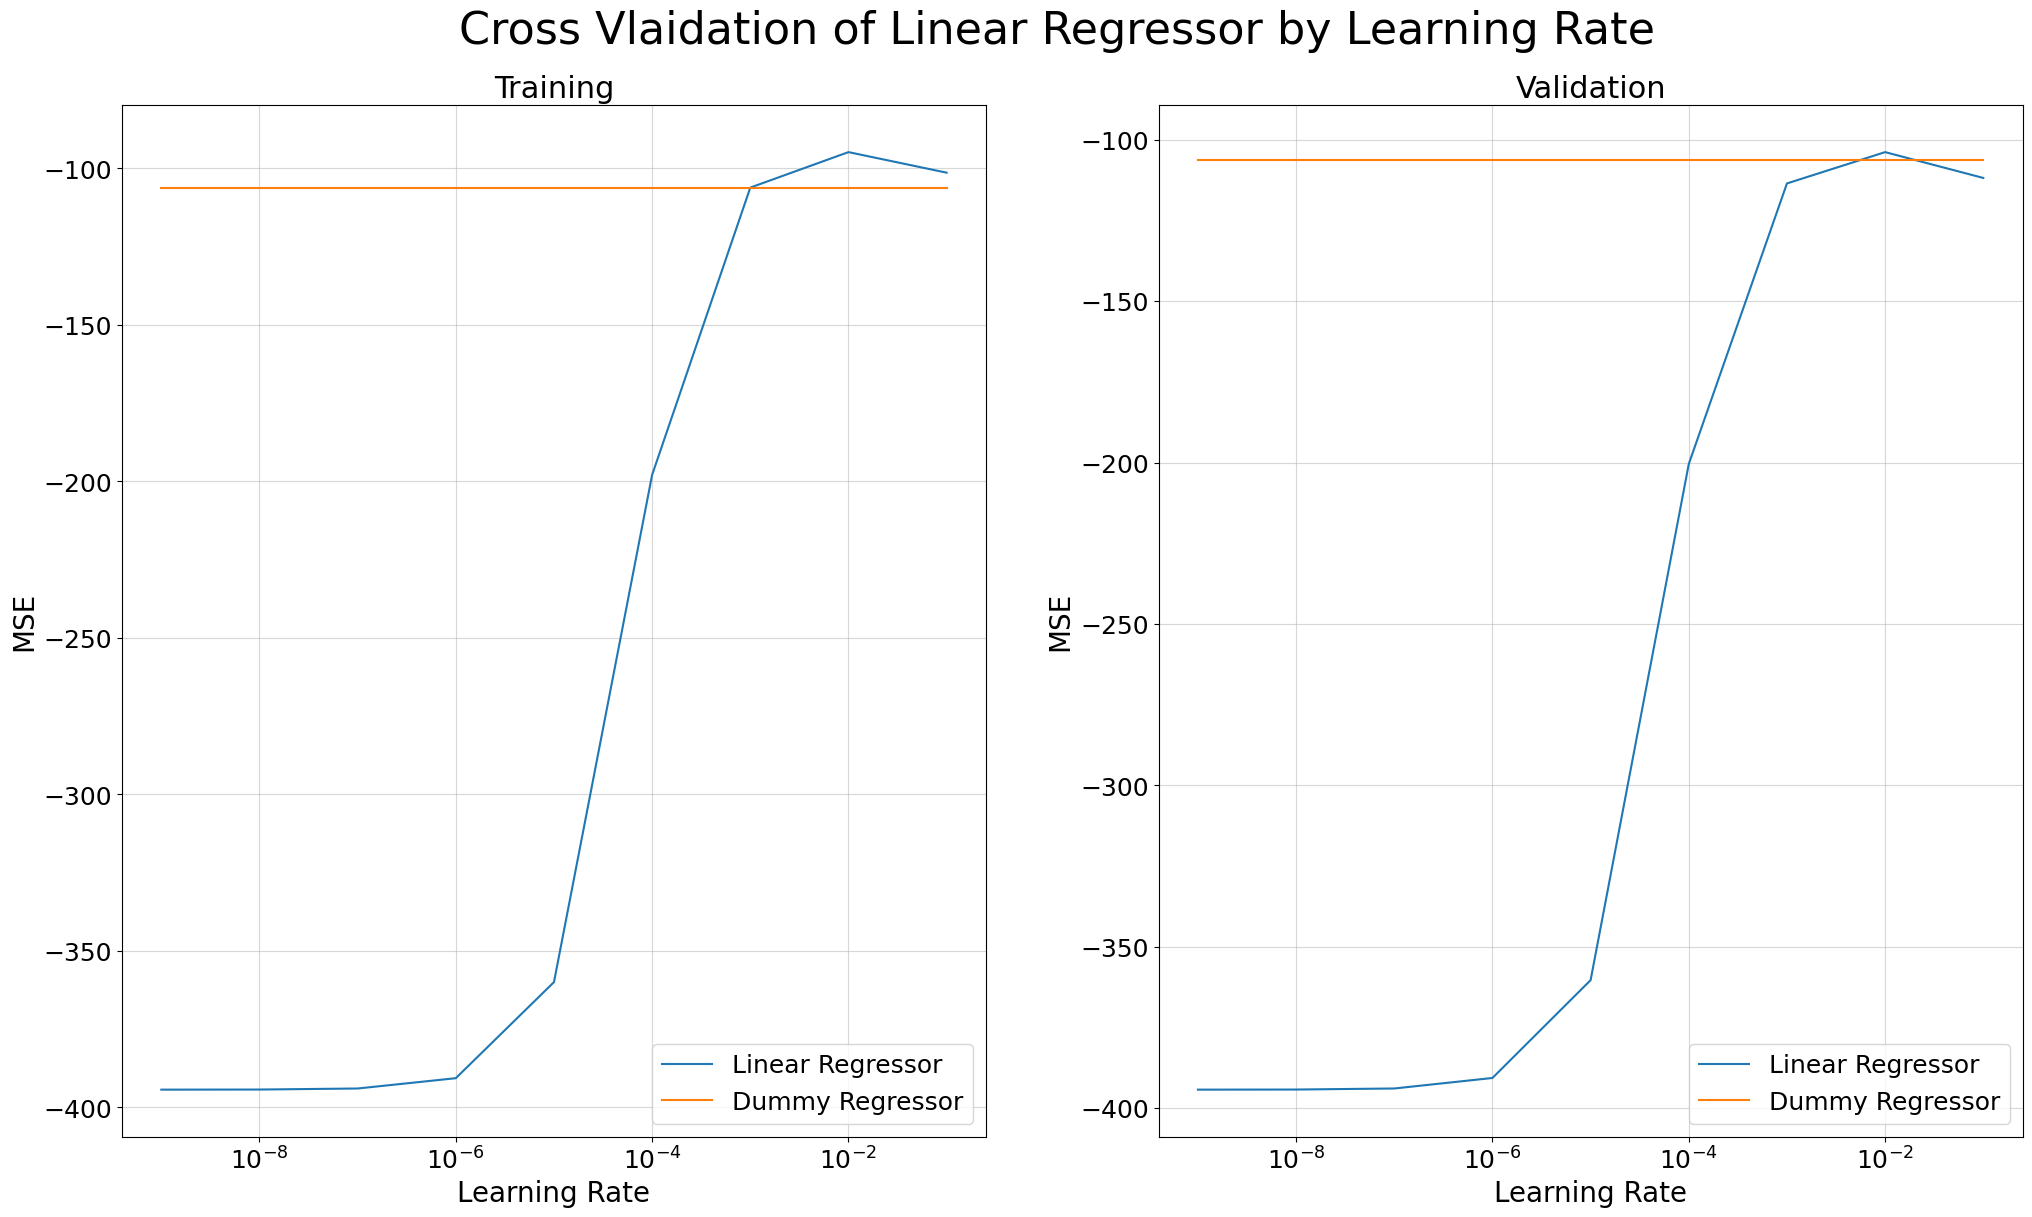

In [14]:
lr_list = np.logspace(-9, -1, 9)
mean_train_score = []
mean_val_score = []

for lr in lr_list:
    cur_linear_reggressor = LinearRegressor(lr)
    cv_lin_regr_scores = cross_validate(cur_linear_reggressor, train_X, train_y, scoring="neg_mean_squared_error", cv=5, return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_lin_regr_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_lin_regr_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(lr_list, mean_train_score, mean_val_score, dummy_mean_train, dummy_mean_val, "Learning Rate", "Linear Regressor")

In [15]:
max_val_idx = np.argmax(mean_val_score)
print(f"The optimal learning rate is {lr_list[max_val_idx]} which achieved a training loss of {mean_train_score[max_val_idx]} and validation loss of {mean_val_score[max_val_idx]}")

The optimal learning rate is 0.01 which achieved a training loss of -94.77876756088419 and validation loss of -103.8076036778778


In [16]:
linear_regressor = LinearRegressor(lr = lr_list[max_val_idx])
linear_regressor.fit(train_X, train_y)

LinearRegressor(lr=0.01)

# Section 3: Linear Regressor with Lasso

# Question 7

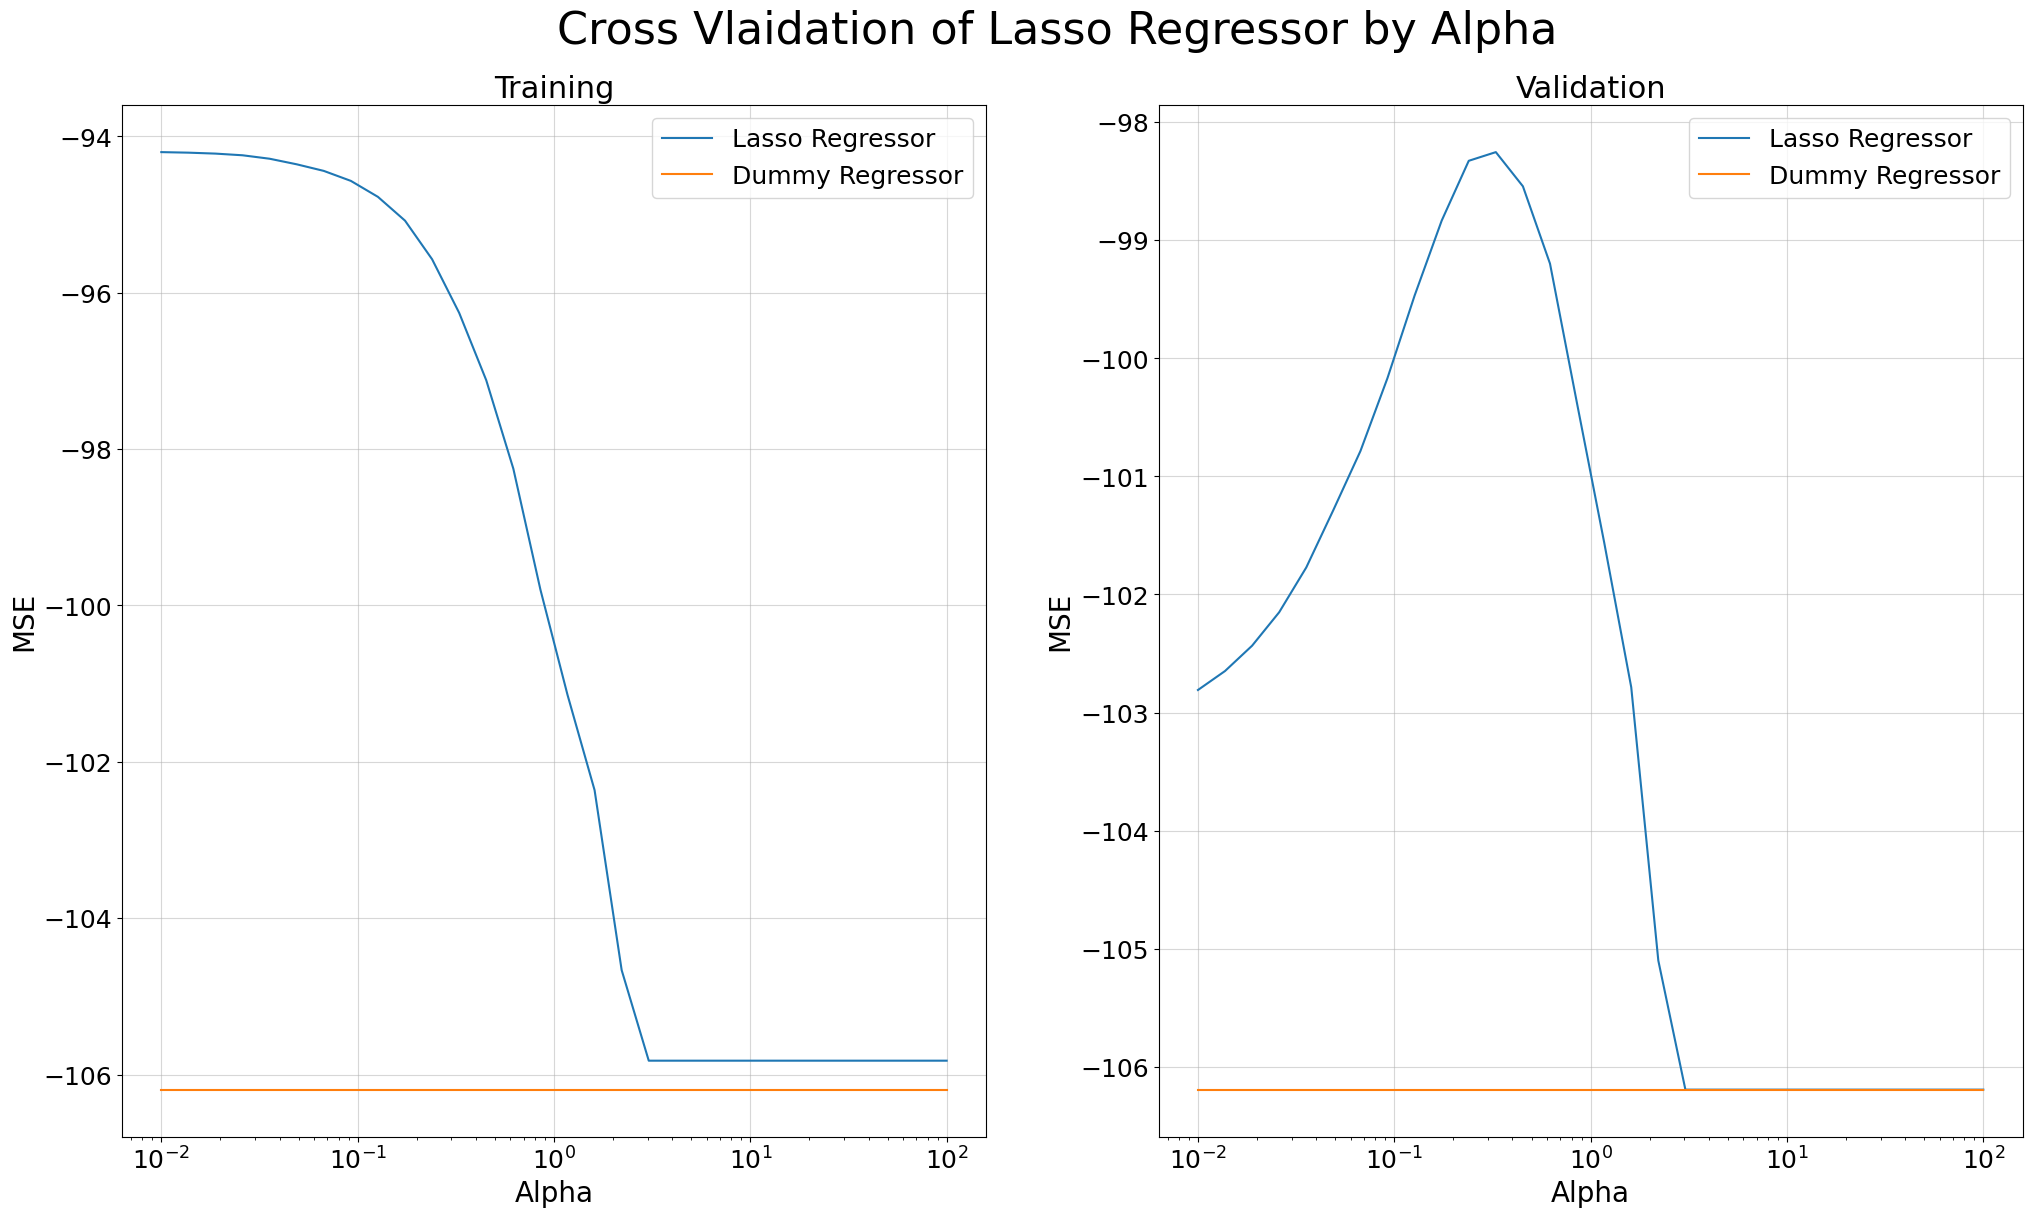

In [17]:
from sklearn.linear_model import Lasso

alpha_list = np.logspace(-2, 2, 30)
alpha_list = [0] + alpha_list
mean_train_score = []
mean_val_score = []

for alpha in alpha_list:
    cur_lasso = Lasso(alpha = alpha, fit_intercept=True)
    cv_lasso_scores = cross_validate(cur_lasso, train_X, train_y, scoring="neg_mean_squared_error", cv=5, return_train_score=True)
    mean_train_score = np.append(mean_train_score, np.mean(cv_lasso_scores['train_score']))
    mean_val_score = np.append(mean_val_score, np.mean(cv_lasso_scores['test_score']))

dummy_mean_train = np.full(shape=mean_train_score.shape, fill_value = dummy_redr_train_loss)
dummy_mean_val = np.full(shape=mean_val_score.shape, fill_value = dummy_redr_val_loss)

semilogx_plot(alpha_list, mean_train_score, mean_val_score, dummy_mean_train, dummy_mean_val, "Alpha", "Lasso Regressor")

In [18]:
opt_alpha_idx = np.argmax(mean_val_score)
opt_alpha = alpha_list[opt_alpha_idx]
print(f"The optimal alpha is {opt_alpha} which achieved a training loss of {mean_train_score[opt_alpha_idx]} and a validation loss of {mean_val_score[opt_alpha_idx]}")

The optimal alpha is 0.32903445623126676 which achieved a training loss of -96.25792220748835 and a validation loss of -98.25465046897469


In [19]:
lasso_regressor = Lasso(alpha = opt_alpha, fit_intercept=True)
lasso_regressor.fit(train_X, train_y)

Lasso(alpha=0.32903445623126676)

In [20]:
abs_coef = np.abs(lasso_regressor.coef_)
opt_coef_idx = np.argsort(abs_coef)
print(f"The features with the largest (absolute) coefficient are {train_X.columns[opt_coef_idx[-5:]].values}")

The features with the largest (absolute) coefficient are ['household_income' 'num_of_siblings' 'PCR_05' 'PCR_01' 'sugar_levels']


# Question 10

Text(0, 0.5, 'Feature Coefficient')

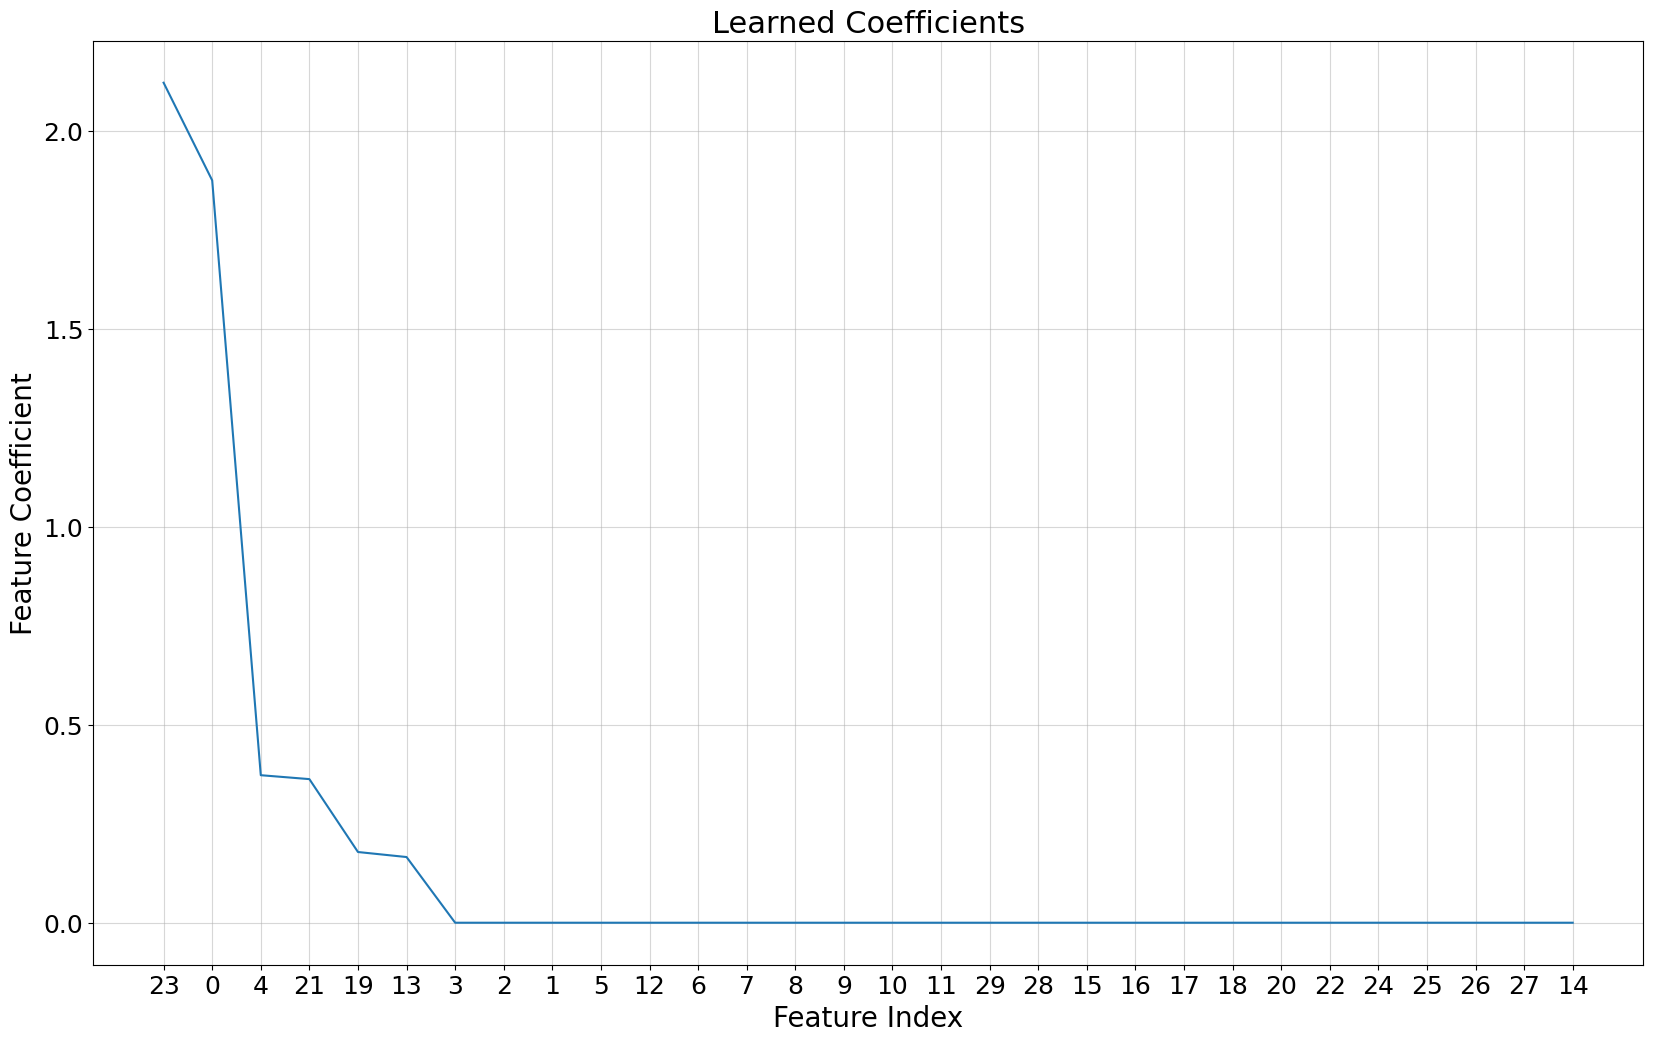

In [21]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(abs_coef[np.flip(opt_coef_idx)])
plt.xticks(ticks = list(range(0, opt_coef_idx.size)),labels = np.flip(opt_coef_idx))

ax.grid(alpha = 0.5)
ax.set_title("Learned Coefficients")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Feature Coefficient")

# Section 4: Polynomial fitting (visualization)

# Question 13

In [22]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

C:\Users\manor\AppData\Local\Temp\ipykernel_19700\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


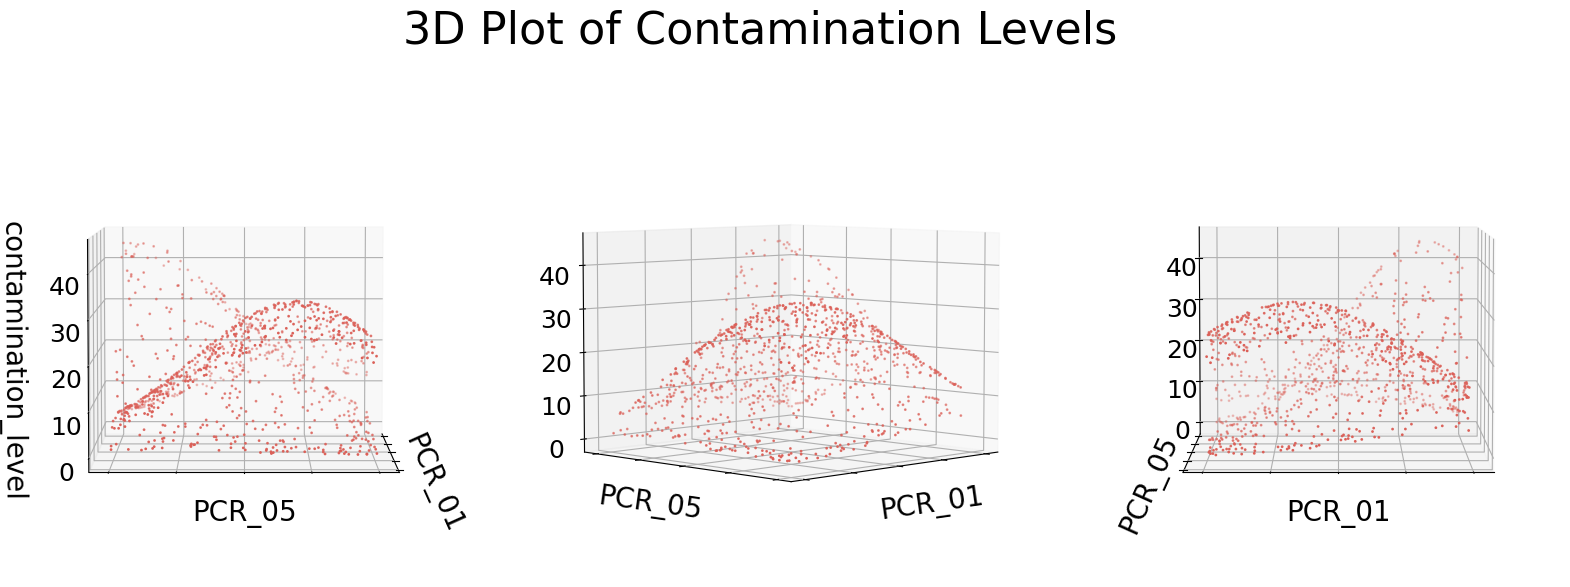

In [23]:
plot3d(train, colX="PCR_01", colY="PCR_05", colZ="contamination_level", title="3D Plot of Contamination Levels")